# **Project: Anomaly Detection for AITEX Dataset**
#### Track: DRÆM
## `Notebook 2`: Data Preparation for DRÆM
**Author**: Oliver Grau 

**Date**: 27.03.2025  
**Version**: 1.0


## 📚 Table of Contents

- [1. Existing Preprocessing & Dataset Class](#1-existing-preprocessing--dataset-class)
- [2. What Needs to Be Adapted for DRÆM?](#2-what-needs-to-be-adapted-for-dræm)
- [3. Goals for This Notebook](#3-goals-for-this-notebook)
- [4. Reuse the FabricPatchDataset](#4-reuse-the-fabricpatchdataset)
- [5. Purpose of the `DRÆMDataset`](#5-purpose-of-the-dræmdataset)
- [6. Conclusion & Next Steps](#6--conclusion--next-steps)

---

## 1. Existing Preprocessing & Dataset Class

In previous experiments (VAE, PatchCore), we created a **pre-patched dataset** using:

- Manual cropping of the fabric area via gradient detection.
- 256×256 non-overlapping grayscale patches.
- Optional histogram equalization.
- Labels derived from presence/absence of mask content.
- Data loader: `FabricPatchDataset` (PyTorch)

### 💡 FabricPatchDataset Features

- Patch loading from image and (optionally) mask folder.
- Mode: `'train'` or `'test'`
- Normalization: `[0, 1]` or z-score
- Histogram equalization: optional
- Repeat grayscale channels to 3: optional
- Label for patch: `1 = defective`, `0 = normal`

## 2. What Needs to Be Adapted for DRÆM?

DRÆM expects a **different training setup**:

| Component | PatchCore | DRÆM |
|----------|-----------|------|
| Training data | Only normal patches | Only normal patches ✅ |
| Labels | Used only for test | Used only for test ✅ |
| Training augmentations | Usually basic (flip, hist eq.) | Strong **synthetic anomaly generation** ✅ |
| Output | Image-level score | **Pixel-wise mask + reconstruction** ✅ |

### ✅ Current dataset is largely reusable!

But:

#### 🔁 We'll add a **DRÆMDataset class**:
- Returns:
  - **original patch**
  - **synthetically corrupted patch**
  - **binary anomaly mask** (showing where corruption was added)

> These masks are used as targets for DRÆM’s anomaly segmentation head during training.


## 3. Goals for This Notebook

- ✅ Reuse the `FabricPatchDataset` to extract all **normal** patches for training.
- ✅ Export/convert them to a folder (`train_normal_patches/`) for use in DRÆM.
- ✅ Define the `DRÆMDataset` class that:
  - Applies **corruptions** on-the-fly
  - Returns `(original, corrupted, mask)` triplets

## 4. Reuse the FabricPatchDataset

We use the existing **FabricPatchDataset** to save intact patches to a special directory for DRAEM.

We use the already created code for the FabricPatchDataset:

In [1]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from codebase.data.dataset import FabricPatchDataset
from torch.utils.data import DataLoader

batch_size = 128

# Test the train dataset
train_dataset = FabricPatchDataset(
    image_dir="artifacts/preprocessed_patches/256x256/NODefect", #/2311517-195063u",
    mode="train",
    normalize="zero-one",
    augment=False,
    image_size=256,
    use_histogram_equalization=False,
    repeat_3_channels=False,
    #fabric_code="00004" # 210 images with that code
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Test the test dataset
test_dataset = FabricPatchDataset(
    image_dir="./artifacts/preprocessed_patches/256x256/Defect",
    mask_dir="./artifacts/preprocessed_patches/256x256/Mask",
    mode="test",
    normalize="zero-one",
    image_size=256,
    use_histogram_equalization=False,
    repeat_3_channels=False,
    augment=False
    #fabric_code="00004" # there are 73 defect images with that code
)

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for i, (x, y_mask, y_label, filename, idx) in enumerate(test_loader):
    print("Image batch shape:", x.shape)
    print("Mask batch shape:", y_mask.shape)
    print("Patch-level labels:", y_label)
    print("Filename:", filename)
    print("Index:", idx)
    break  # just one batch for demonstration

Using FFT transform: False
Using histogram equalization: False
Using image size: 256
Using channel repeating: False
Using normalization: zero-one
Using augmentations: False
Using FFT transform: False
Using histogram equalization: False
Using image size: 256
Using channel repeating: False
Using normalization: zero-one
Using augmentations: False
Image batch shape: torch.Size([128, 1, 256, 256])
Mask batch shape: torch.Size([128, 1, 256, 256])
Patch-level labels: tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
Filename: ('defect_00000_00283.png', 'defect_00000_00284.png', 'defect_00000_00286.png', 'defect_00000

Then we save the normal patches in a directory where the upcoming and to be created **DRAEMDataset** will work on:

In [2]:
from PIL import Image
import os
from PIL import Image
from torchvision import transforms

export_folder = "./artifacts/preprocessed_patches/256x256/draem_normal_data/"
os.makedirs(export_folder, exist_ok=True)

for i in range(len(train_dataset)):
    patch_tensor = train_dataset[i]  # shape [1, H, W] or [3, H, W]
    
    # Convert to PIL
    pil_img = transforms.ToPILImage()(patch_tensor)
    pil_img.save(os.path.join(export_folder, f"normal_{i:05d}.png"))

---

## 5. Purpose of the `DRÆMDataset`

The **goal** of DRÆM is to train a model to reconstruct *normal-looking* images — even from corrupted input. It learns to **denoise or "inpaint" corrupted images**, and we supervise the model by providing the *true location of the corruption* via masks.

So the dataset must return:

- **original image** (target for the reconstruction)
- **corrupted image** (input for the model)
- **mask** (tells which pixels were corrupted)

### 🧱 Core Design Principles

#### 1. **Loading Normal Patches**
```python
self.image_paths = sorted([
    os.path.join(root, fname)
    for root, _, files in os.walk(image_dir)
    for fname in files
    if fname.lower().endswith(('.png', '.jpg', '.jpeg'))
])
```
We use only normal patches as input because DRÆM is **unsupervised** — it learns by reconstructing clean data that we synthetically corrupt ourselves.

#### 2. **Apply Transform to Original**
```python
self.transform = transforms.Compose([...])
original = self.transform(Image.open(img_path).convert("L"))
```
We apply resizing, grayscale conversion, normalization — so that both original and corrupted images are processed identically (except for the corruption).

#### 3. **Corrupt Image On-the-Fly**
```python
corrupted, mask = self._apply_random_corruption(original.clone())
```
Corruption is applied each time the image is fetched:
- This keeps the model from **overfitting to specific noise patterns**
- It enables **data augmentation** without growing the dataset size

#### 4. **Return Triplets**
```python
return original, corrupted, mask
```
This structure enables training a model like this:
```python
reconstructed = model(corrupted)
loss = loss_fn(reconstructed, original, mask)
```

### 🧪 Summary

- ✅ **Normal images only** for training
- ✅ **Corruption is added dynamically** (so it's always fresh)
- ✅ **Triplet output** is perfect for supervised reconstruction
- 🔥 This design is powerful, lightweight, and enables generalization to *real* defects later!

---

The code of the dataset can be found in ``dataset_utils/draem/dataset.py``. Now let's use it with no special corruption_transformations:

In [3]:
import torchvision.transforms as T
from codebase.data.draem.dataset import DRAEMDataset

# basic transforms (many transforms are already applied by the FabricPatchDataset
base_transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    # T.Normalize(mean=[0.5], std=[0.5]) etc.
])

dataset = DRAEMDataset(
    normal_folder="./artifacts/preprocessed_patches/256x256/draem_normal_data",
    base_transform=base_transform,
    corruption_transform=None  # or leave None to use random_blob_corruption
)

Let's visualize a few samples from the dataset:

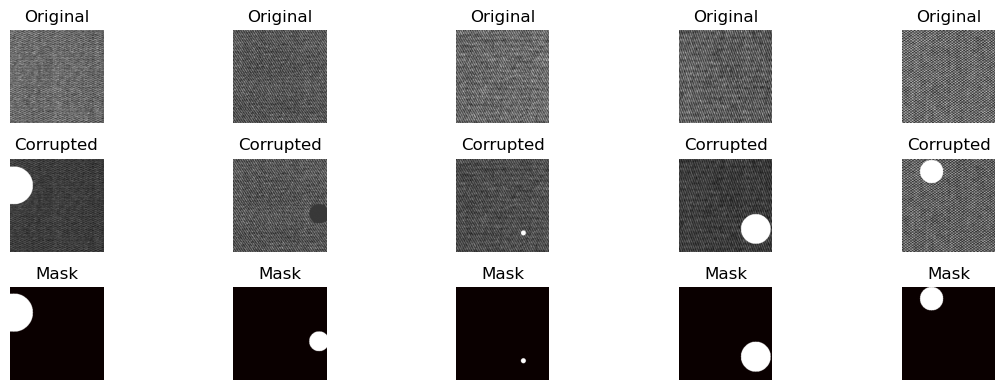

In [4]:
import matplotlib.pyplot as plt

def show_draem_batch(dataset, n: int = 4):
    """
    Plots n samples from the DRÆMDataset in a row: original, corrupted, mask.
    
    Args:
        dataset (DRÆMDataset): The dataset instance.
        n (int): Number of samples to display.
    """
    from torch.utils.data import DataLoader

    loader = DataLoader(dataset, batch_size=n, shuffle=True)
    orig, corrupted, mask = next(iter(loader))  # one batch

    plt.figure(figsize=(12, 4))
    for i in range(n):
        # Original
        plt.subplot(3, n, i + 1)
        plt.imshow(orig[i].squeeze().cpu(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Corrupted
        plt.subplot(3, n, n + i + 1)
        plt.imshow(corrupted[i].squeeze().cpu(), cmap="gray")
        plt.title("Corrupted")
        plt.axis("off")

        # Mask
        plt.subplot(3, n, 2 * n + i + 1)
        plt.imshow(mask[i].squeeze().cpu(), cmap="hot")
        plt.title("Mask")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_draem_batch(dataset, n=5)

In the next notebook we will implement optimized anomaly functions for our AITEX based data.

---

### ✅ **Question: Does `DRAEMDataset` need a `mode` (train/test)?**

**Short answer:**  
**No — the basic `DRAEMDataset` does *not* need modes.**

**Why?**

- The **dataset is only used for training** on *normal* patches.
- During training, it returns:
  - `original` → clean image (target)
  - `corrupted` → synthetically noised version (input)
  - `mask` → indicates which pixels were corrupted

- During **validation/testing**, you **don't use this dataset** — instead, you:
  - Use your **real test set** with possibly *real* defects (e.g., from `FabricPatchDataset`).
  - Pass test images through your trained model and evaluate the **reconstruction error** or **segmentation mask output**.


#### In Summary

| Dataset | Purpose | Needs a mode? |
|--------|--------|----------------|
| `DRAEMDataset` | Train on *clean* data with synthetic noise | ❌ No |
| `FabricPatchDataset` (or test loader) | Evaluate on real or masked images | ✅ Yes (train/test distinction for mask availability) |

---

## 6. 🔚 Conclusion & Next Steps

In this notebook, we laid the foundation for training a DRÆM model by preparing a specialized dataset for anomaly detection. The focus was on building a foundation for a flexible data pipeline and generating synthetic anomalies along with corresponding segmentation masks.

### ✅ Key Accomplishments:
- Clean separation of training and test sets  
- Implementation of a flexible `DRAEMDataset` class  
- Generation and visualization of synthetic anomalies with corresponding masks  

These prepared samples form the core for training a DRÆM model in a semi-supervised setting. By combining the original image with a reconstructed output and a segmentation mask, we enable the model to learn both reconstruction and precise anomaly localization.

---

### 🔜 What’s Next

In the next notebook, we’ll move on to create anomalies and an anomaly pipeline. Key topics will include:

- Creating anomalies which can be used as corruption functions for the DRAEMDataset
- Creating a flexible AnomalyPipeline which can apply all anomalies in a controlled way in the DRAEMDataset


👉 Up next: **03.1_Synthetic Anomaly Generation.ipynb**

<p style="font-size: 0.8em; text-align: center;">© 2025 Oliver Grau. Educational content for personal use only. See LICENSE.txt for full terms and conditions.</p>